In [1]:
# imports
import cv2
import numpy as np
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import make_grid, save_image
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import matplotlib.pyplot as plt
import os
from IPython.display import Image
%matplotlib inline

In [ ]:
# new

In [2]:
#### Main config parameters
RANDOM_SEED = 42
C = 0.05 # CLip value for WGAN
N_SAMPLES = 10000
IMAGE_SIZE = 64
BATCH_SIZE = 128

LR = 0.00025
EPOCHS = 60


# GAN mode to use, either lsgan, gan or wgan
MODE = 'lsgan'

# CONTROLS Number of times critic is updated for each update to generator model
N_CRITIC = 5 

# Set Latent Space Dimension for generator to use for image generation
LATENT_SIZE = 128

# WORKING_DATA_DIR = os.path.join(
#     os.getcwd(), 
#     'data',
#     'img_align_celeba',
#     'sample',
#     'train'
# )
# SAMPLE_DIR_GENERATED_IMAGE = os.path.join(os.getcwd(), 'generated', MODE)

# Torch config for reproducibility
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
DATA_DIR =  "../input/celeba-dataset/img_align_celeba/img_align_celeba/"
WORKING_DATA_DIR_ROOT = "/kaggle/working/data/"
WORKING_DATA_DIR = "/kaggle/working/data/train"

images = os.listdir(DATA_DIR)
# make new_path
os.makedirs(WORKING_DATA_DIR_ROOT)
os.makedirs(WORKING_DATA_DIR)

In [4]:
# shutil.rmtree(WORKING_DATA_DIR_ROOT, ignore_errors=True)

In [5]:
# comment out as folder is created
for i in images[:10000]:
    from_path = os.path.join(DATA_DIR,i)
    Destination_path = os.path.join(WORKING_DATA_DIR,i)
    shutil.copy(from_path,Destination_path)

In [6]:
def cal_mean_std(images_dir):
    """
    Calculates mean and standard deviation of images channel in a given directory using cv2 meanStdDev library. The mean and standard deviation are in BGR channel order

    Args:
        images_dir (string): Directory storing images to be referred to for channel mean/std calculation.

    Returns:
        mean_arr (numpy array): 2D numpy array representing the mean values in BGR channel
        std_dev_arr (numpy array): 2D numpy array representing the standard deviation of values in BGR channel
    Raises:
        IOError: File doesnt exist.
    """
    img_filenames = os.listdir(images_dir)
    mean_list, std_list = [], []

    for img_filename in img_filenames:
        try:
            img = cv2.imread(os.path.join(images_dir, img_filename))
            img = img / 255.0
            m, s = cv2.meanStdDev(img)

            mean_list.append(m.reshape((3,)))
            std_list.append(s.reshape((3,)))
        except:
            raise IOError
        
    mean_array = np.array(mean_list)
    std_array = np.array(std_list)
    mean_arr = mean_array.mean(axis=0, keepdims=True)
    std_dev_arr = std_array.mean(axis=0, keepdims=True)

    return mean_arr, std_dev_arr



In [7]:
mean, std = cal_mean_std(WORKING_DATA_DIR)
print(mean, std)

# RGB mean and std for normalisation from dataset
stats = tuple(mean.squeeze(0)[::-1]), tuple(std.squeeze(0)[::-1])

[[0.38167551 0.42465283 0.50582571]] [[0.24255724 0.24676923 0.26725957]]


In [8]:
image_transformer = T.Compose([
    T.Resize(IMAGE_SIZE),
    T.CenterCrop(IMAGE_SIZE), # Central square crop
    T.ToTensor(),
    T.Normalize(*stats)   # normalize => -1 to 1                               
])


train_ds = ImageFolder(
#     root='../input/celeba-dataset/img_align_celeba/',
    root=os.path.dirname(WORKING_DATA_DIR),
    transform=image_transformer
)

train_dl = DataLoader(
    train_ds, 
    BATCH_SIZE,
    shuffle=True,
    num_workers=3,# use some cores
    pin_memory=True # Speed up host to device transfer for training on gpu
) 


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [9]:
def denorm(img_tensors):
    "Denormalize image tensor with specified mean and std"
    return img_tensors * stats[1][0] + stats[0][0]

# Helper function to show images

def show_images(images, nmax=64):
  fig, ax = plt.subplots(figsize=(8,8))
  ax.set_xticks([]); ax.set_yticks([])

  #In Pytorch -> C x Hx W whereas Matplotlib reques H x W x C. So, permute(1, 2, 0) do this.
  ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
  return None
  
def show_batch(dl, nmax=64):
  for images, _ in dl:
    show_images(images, nmax)
    break

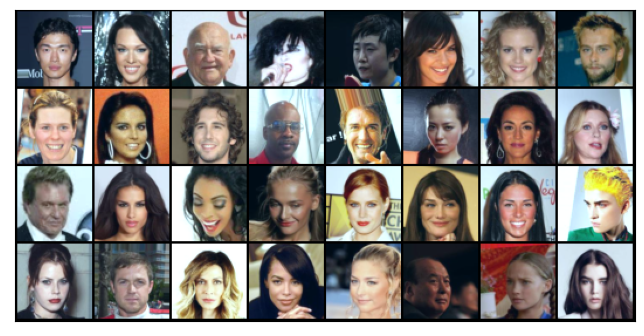

In [10]:
show_batch(train_dl, nmax=32)

In [11]:
def to_device(data, device):
    """Move all data types to provided device index
    
    Args:
        data (torch tensor): Data in torch tensor
        device (torch device): Device info/index for data loading

    Returns:
        Data loading to device input stated

    Raises:
        None
    
    """
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device that is detected in batches.
    
    """
    def __init__(self, dl, device):
        """Constructor to instantiate dataloader and device attributes for the class.
    
        Args:
            dl (torch dataloader): Pytorch dataloader
            device (torch device): Device info/index for data loading

        Returns:
            None

        Raises:
            None
        
        """
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device
        
        Args:
            Mone

        Returns:
            None

        Raises:
            None
        
        """
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Return size of data batches in dataloader
        Args:
            Mone

        Returns:
            Size of data batchers in dataloader

        Raises:
            None
        
        """
        return len(self.dl)

In [12]:
device = torch.device('cuda')

In [13]:
train_dl = DeviceDataLoader(train_dl, device)

In [15]:
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torchvision
import torchvision.models as models

vgg16 = models.vgg16_bn()
for param in vgg16.features.parameters():
    param.require_grad = False
pretrained_layers = [*(list(vgg16.children())[:-1])]
customised_layers = [
    # in: 3x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    # Flatten to provide output whether isit 1 or 0
    nn.Flatten(),

    # To decide if a generated image is fake/real based on real image
    nn.Sigmoid()

]

discriminator = nn.Sequential(
    *(pretrained_layers + customised_layers )
)

critic = nn.Sequential(
    # in: 3x 64 x 64
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    # Flatten to provide output whether isit 1 or 0
    nn.Flatten(),

    # To output a value (like regression)
    nn.Linear(1,1)
)

In [16]:
if MODE == 'gan':
    discriminator = to_device(discriminator, device)
else:   
    discriminator = to_device(critic, device)

In [17]:
# create a tensor Batch_Size,C,H,W
X = torch.rand(size=(1, 3, 64, 64), dtype=torch.float32, device=device) 
for layer in discriminator:
    X = layer(X)
    print(layer.__class__.__name__,'output shape: \t',X.shape)

Conv2d output shape: 	 torch.Size([1, 64, 32, 32])
BatchNorm2d output shape: 	 torch.Size([1, 64, 32, 32])
LeakyReLU output shape: 	 torch.Size([1, 64, 32, 32])
Conv2d output shape: 	 torch.Size([1, 128, 16, 16])
BatchNorm2d output shape: 	 torch.Size([1, 128, 16, 16])
LeakyReLU output shape: 	 torch.Size([1, 128, 16, 16])
Conv2d output shape: 	 torch.Size([1, 256, 8, 8])
BatchNorm2d output shape: 	 torch.Size([1, 256, 8, 8])
LeakyReLU output shape: 	 torch.Size([1, 256, 8, 8])
Conv2d output shape: 	 torch.Size([1, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([1, 512, 4, 4])
LeakyReLU output shape: 	 torch.Size([1, 512, 4, 4])
Conv2d output shape: 	 torch.Size([1, 1, 1, 1])
Flatten output shape: 	 torch.Size([1, 1])
Linear output shape: 	 torch.Size([1, 1])


In [18]:
generator = nn.Sequential(
    # input: latent vector of latent_size x 1 x 1

    nn.ConvTranspose2d(LATENT_SIZE, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()  # output is between -1 to 1
    # out: 3 x 64 x 64
)

In [19]:
X = torch.randn(size=(1, 128, 1, 1))
for layer in generator:
  X = layer(X)
  print(layer.__class__.__name__,'output shape: \t',X.shape)

ConvTranspose2d output shape: 	 torch.Size([1, 512, 4, 4])
BatchNorm2d output shape: 	 torch.Size([1, 512, 4, 4])
ReLU output shape: 	 torch.Size([1, 512, 4, 4])
ConvTranspose2d output shape: 	 torch.Size([1, 256, 8, 8])
BatchNorm2d output shape: 	 torch.Size([1, 256, 8, 8])
ReLU output shape: 	 torch.Size([1, 256, 8, 8])
ConvTranspose2d output shape: 	 torch.Size([1, 128, 16, 16])
BatchNorm2d output shape: 	 torch.Size([1, 128, 16, 16])
ReLU output shape: 	 torch.Size([1, 128, 16, 16])
ConvTranspose2d output shape: 	 torch.Size([1, 64, 32, 32])
BatchNorm2d output shape: 	 torch.Size([1, 64, 32, 32])
ReLU output shape: 	 torch.Size([1, 64, 32, 32])
ConvTranspose2d output shape: 	 torch.Size([1, 3, 64, 64])
Tanh output shape: 	 torch.Size([1, 3, 64, 64])


In [20]:
generator = to_device(generator, device)

In [21]:
def train_discriminator(real_images,
                        opt_d,
                        batch_size=64,
                        latent_size=128,
                        mode='wgan'):
    """Function that constructs the process of discriminator training
    
    Args:
        real_images (torch tensor): 
            Data in torch tensor
        batch_size (int): 
            Batch size of data for each pass. Defaults to 64.
        latent_size (int):
            Vector size of latent variable. Defaults to 128.
        opt_d (optimizer):
            Torch optimizer function
        mode (string): 
            GAN mode that affects the loss function used

    Returns:
        loss.item (torch): 
            Loss information by discriminator
        real_score (float):
            Measures how well it is able to discriminate  real image
        fake_score (float):
            Measures how well it is able to discriminate generated image
    Raises:
        NotImplementedError: For other mode types not belonging to gan/lsgan/wgan

    
    """
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Real image case: Pass real images through  discriminator and assign value 1 to indicate real
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    
    # Fake image case: Generate fake image using latent vector for a batch of data
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass Fake images through discriminator and declare them as 0 since we want discriminator to be 0
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)

    if mode=='gan':
        real_loss = F.binary_cross_entropy(real_preds, real_targets)
        fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
        loss = real_loss + fake_loss
        # Combine loss and backward propagate
        loss.backward()
        opt_d.step()

    elif mode=='lsgan':

        # L2 loss function for discriminatorinvolving (D(x) - b) and D(G(z))-a) where a is label for fake data and b is label for real data.

        mse_loss = torch.nn.MSELoss()
        real_loss = mse_loss(real_preds, real_targets)
        fake_loss = mse_loss(fake_preds, fake_targets)
        loss = 0.5 * (real_loss + fake_loss)

        loss.backward()
        opt_d.step()
    
    elif mode== 'wgan':
        # The discriminator doesnt really classify, but output a number (bigger for real than for fake) aka Critic loss. D(x) - D(G(z)). Since Discriminator needs to maximize this, it is equivalent to minimizing the negative of this.

        loss = -(real_preds.mean() - fake_preds.mean())
        
        loss.backward()
        opt_d.step()

        # Clip weights to be in a constrained value. This is to enforce the Lipschitz constraint on the critic’s model to
        c = C
        
        # Clamp values to constrained range
        for p in discriminator.parameters():
            p.data.clamp_(-c, c)
    else:
        raise NotImplementedError
    
    real_score = torch.mean(real_preds).item()

    fake_score = torch.mean(fake_preds).item()
    return loss.item(), real_score, fake_score



In [22]:
def train_generator(opt_g, batch_size=64, latent_size=128, mode = 'wgan'):
    """Function that implements the generator model process in generating image for discriminator to be fooled and calculates the losses obtained using discriminator response against supposedly real labels (response =1)

    Args:
        opt_g (optimizer):
            Torch optimizer for generator
        batch_size (int):
            Amount of batch data to be generated using stated latent_size vector. Defaults to 64
        latent_size (int):
            Vector size of latent variable. Default to 128.
        mode (string):
            GAN mode determining the loss function to use

    Returns:
        loss.item() (tensor contents): Contents of generator loss values

    Raises:
        NotImplementedError: When modes are not gan or lsgan or wgan
    
    """
    # Clear generator gradients before training
    opt_g.zero_grad()

    # Generate fake images of batch_size using latent_vector
    latent = torch.randn(batch_size, latent_size, 1,1, device=device)
    fake_images = generator(latent)

    # Send image for discriminator response
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)

    if mode =='gan':
        loss = F.binary_cross_entropy(preds, targets)

    elif mode =='lsgan':
        # Similar to a-b decoding scheme in discriminator we now set label as 1 as we want generator to generate images that are as real as possible, hence -1
        mse_loss = torch.nn.MSELoss()
        loss = mse_loss(preds, targets)

    elif mode == 'wgan':
        # Evaluate mean of predictions for generated images
        loss = -preds.mean()
        
    else:
        raise NotImplementedError
    # Calculate loss based on response value and supposed 'real' target


    # Update generator 
    loss.backward()
    opt_g.step()

    return loss.item()

In [23]:
SAMPLE_DIR_GENERATED_IMAGE = os.path.join(
                                          WORKING_DATA_DIR_ROOT,
                                          'generated')
os.makedirs(SAMPLE_DIR_GENERATED_IMAGE , exist_ok=True)

In [24]:
def save_samples(index, sample_dir, latent_tensors, show=True):
    """Function that saves generated image using provided latent tensors, while providing visualisation if show argument is True

    Args:
        index (int):
            Index for use in file name of image used for saving.
        sample_dir (string):
            Directory to store generated images.
        latent_tensors (torch tensor):
            Torch tensor representation of tensor to be used for generating fake images.
    Returns:
        None
    Raises:
        None
    
    """
    # Create fake images
    fake_images = generator(latent_tensors)

    # Filenamem for generated image
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)

    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print("Saving", fake_fname)

    # Plot out generated image using subplot
    if show:
        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))
    
    return None

In [25]:
def fit(epochs, lr, batch_size, latent, sample_dir, mode='wgan'):
    """This functions implements the training process for generator and discriminator, with discriminator learning to identify real images before discriminating fake images
    
    Args:
      epochs (int): 
        Number of epochs for model training
      lr (float):
        Learning rate for gradient descent
      batch_size (int):
        Size of batches to be used for fitting 
      latent (torch tensor):
        Latent tensor for generating image
      sample_dir (string):
            Directory to store generated images.
      mode (string):
        GAN modes to determine the loss function for use

    Returns:
        losses_g (list): Measures losses of generator
        losses_d (list): Measures losses of discriminator
        real_scores (list): Measures the discriminator performance on identifying real images
        fake_scores (list): Measures how well it is able to discriminate generated image as fakes.
    Raises:
        None
    
    """
    # Empty any content in cuda 
    torch.cuda.empty_cache()

    # Losses & scores for generator and discriminator
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers for discriminator
    opt_d = torch.optim.Adam(discriminator.parameters(), 
                             lr=lr,
                             betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(),
                             lr=lr,
                             betas=(0.5, 0.999))

   
    # Loop through epoch and include losses and scores for both generator and discriminator. For LSGAN and DCGAN, updates are equal.
    # Clearing of gradients are done in train_discriminator and train_generator respectively.
    for epoch in range(epochs):
        for real_images, _ in train_dl:
            
            # Train discriminator with specified optimizer. Becomes critic when in WGAN.

            if mode != 'wgan':
                loss_d, real_score, fake_score = train_discriminator(\
                    real_images,
                    opt_d, 
                    batch_size,
                    latent.shape[1], 
                    mode
                )

            else:
                # Update critic(discriminator) for n_critic
                for _ in range(N_CRITIC):
                    loss_d, real_score, fake_score = train_discriminator(\
                        real_images,
                        opt_d, 
                        batch_size,
                        latent.shape[1], 
                        mode
                )

            # Train generator with specified optimizer
            loss_g = train_generator(
                opt_g,
                batch_size,
                latent.shape[1],
                mode=mode
            )

        # Record losses & scores by epoch (after processing last batch of data in dataloader)
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g for {}: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(epoch+1, epochs, mode, loss_g, loss_d, real_score, fake_score))

        # Save generated images based on GAN mode information
        save_samples(epoch+1, sample_dir, latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

Saving generated-images-0000.png


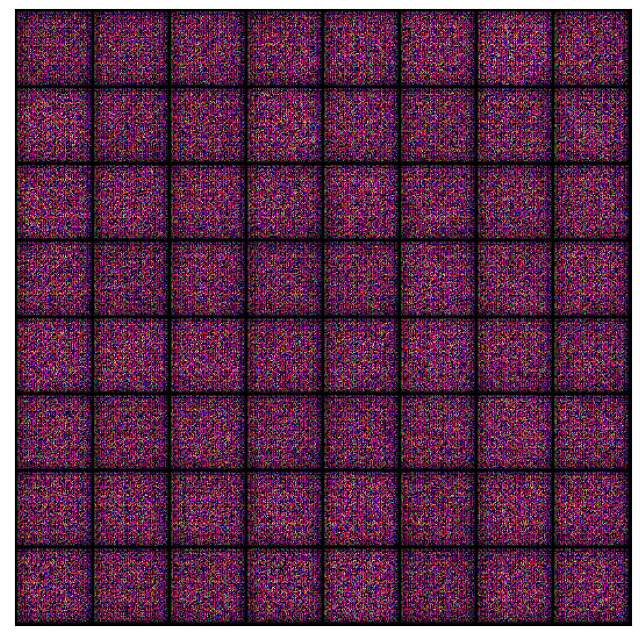

In [26]:
# Matrix of 64 datapoints represented by LATENT_SIZE,1,1 matrix
fix_latent = torch.randn(64, LATENT_SIZE, 1, 1, device=device)
save_samples(0, SAMPLE_DIR_GENERATED_IMAGE, fix_latent)

In [27]:
history = fit(EPOCHS,
              LR,
              BATCH_SIZE,
              fix_latent,
              sample_dir=SAMPLE_DIR_GENERATED_IMAGE,
              mode=MODE)

Epoch [1/60], loss_g for lsgan: 1.5378, loss_d: 0.1009, real_score: 1.0861, fake_score: 0.3416
Saving generated-images-0001.png
Epoch [2/60], loss_g for lsgan: 2.3960, loss_d: 0.0807, real_score: 0.7142, fake_score: 0.2407
Saving generated-images-0002.png
Epoch [3/60], loss_g for lsgan: 0.9993, loss_d: 0.0736, real_score: 0.7137, fake_score: 0.1220
Saving generated-images-0003.png
Epoch [4/60], loss_g for lsgan: 0.8769, loss_d: 0.1968, real_score: 0.5355, fake_score: 0.3687
Saving generated-images-0004.png
Epoch [5/60], loss_g for lsgan: 0.5699, loss_d: 0.0977, real_score: 0.6469, fake_score: -0.0242
Saving generated-images-0005.png
Epoch [6/60], loss_g for lsgan: 0.7850, loss_d: 0.1396, real_score: 0.5068, fake_score: 0.0695
Saving generated-images-0006.png
Epoch [7/60], loss_g for lsgan: 1.0170, loss_d: 0.0354, real_score: 0.8594, fake_score: 0.0901
Saving generated-images-0007.png
Epoch [8/60], loss_g for lsgan: 1.0356, loss_d: 0.0891, real_score: 0.8765, fake_score: 0.3144
Saving g

In [29]:
# Save the model checkpoints of generator and discriminator

# Define state dict name
g_state_dict_name = 'G-{}.pth'.format(MODE)
d_state_dict_name = 'D-{}.pth'.format(MODE)
torch.save(generator.state_dict(), g_state_dict_name)
torch.save(discriminator.state_dict(), d_state_dict_name)

In [30]:
losses_g, losses_d, real_scores, fake_scores = history

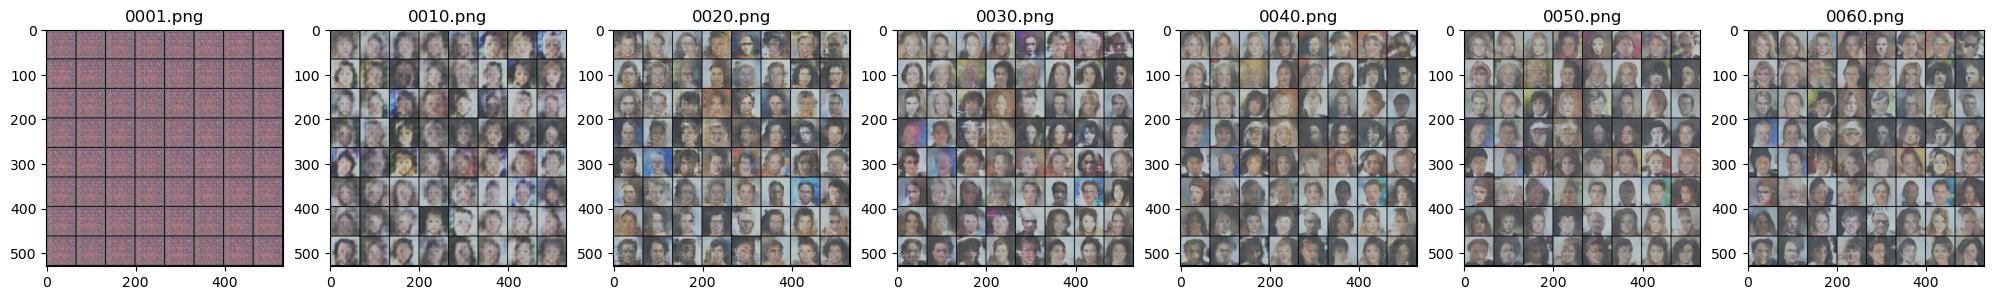

In [31]:
gen_image_id_list = ['0001', '0010', '0020', '0030', '0040', '0050', '0060']

gen_image_path_list = [ os.path.join(WORKING_DATA_DIR_ROOT,
                                     'generated',
                                    'generated-images-{}.png'.format(id)) for id in gen_image_id_list]


fig, ax = plt.subplots(1, len(gen_image_id_list), figsize=(25,25))
for i, gen_image_path in enumerate(gen_image_path_list):
    img = plt.imread(gen_image_path)
    ax[i].imshow(img)
    ax[i].set(title = str(gen_image_id_list[i]) +'.png')


In [32]:
# Define video filename and filepath
vid_fname = 'gans-training-{}-sample-{}.avi'.format(MODE, N_SAMPLES)
vid_fpath = os.path.join(SAMPLE_DIR_GENERATED_IMAGE, vid_fname)

print("Starting converting images to video.")
files = [os.path.join(SAMPLE_DIR_GENERATED_IMAGE, f) for f in os.listdir(SAMPLE_DIR_GENERATED_IMAGE) if 'generated' in f]
files.sort()

print(files)



fourcc = cv2.VideoWriter_fourcc(*'MPEG')
out = cv2.VideoWriter(vid_fpath, fourcc, 1.0, (640,480))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
print("DONE!")

Starting converting images to video.
['/kaggle/working/data/generated/generated-images-0000.png', '/kaggle/working/data/generated/generated-images-0001.png', '/kaggle/working/data/generated/generated-images-0002.png', '/kaggle/working/data/generated/generated-images-0003.png', '/kaggle/working/data/generated/generated-images-0004.png', '/kaggle/working/data/generated/generated-images-0005.png', '/kaggle/working/data/generated/generated-images-0006.png', '/kaggle/working/data/generated/generated-images-0007.png', '/kaggle/working/data/generated/generated-images-0008.png', '/kaggle/working/data/generated/generated-images-0009.png', '/kaggle/working/data/generated/generated-images-0010.png', '/kaggle/working/data/generated/generated-images-0011.png', '/kaggle/working/data/generated/generated-images-0012.png', '/kaggle/working/data/generated/generated-images-0013.png', '/kaggle/working/data/generated/generated-images-0014.png', '/kaggle/working/data/generated/generated-images-0015.png', '/

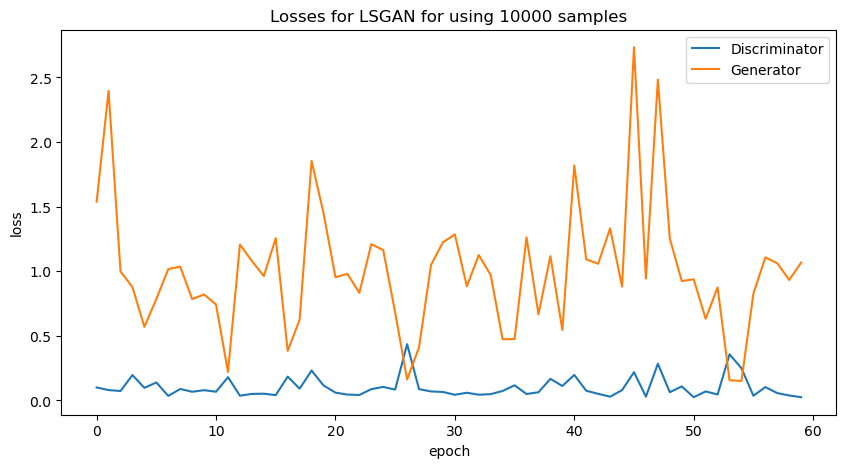

In [33]:
plt.figure(figsize=(10,5))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'], loc='best')
plt.title('Losses for {} for using {} samples'.format(MODE.upper(), N_SAMPLES));

loss_plot_fname = 'loss-{}-sample-{}.png'.format(MODE, N_SAMPLES)
plt.savefig(loss_plot_fname)

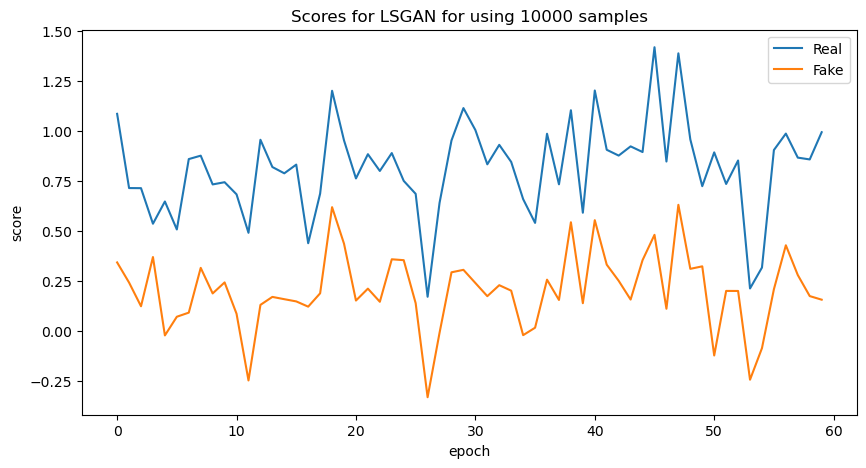

In [34]:
plt.figure(figsize=(10,5))
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'], loc='best')
plt.title('Scores for {} for using {} samples'.format(MODE.upper(), N_SAMPLES));

score_plot_fname = 'score-{}-sample-{}.png'.format(MODE, N_SAMPLES)
plt.savefig(score_plot_fname)